In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_color_codes('deep')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import decomposition

plt.rcParams['figure.figsize'] = (8, 6)

meanprops = {'marker':'o',
             'markerfacecolor':'white', 
             'markeredgecolor':'black',
             'markeredgewidth': 1.5,
             'markersize':'10'}

# Clustering avec la segmentation RFMSA

In [2]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [3]:
df_rfmsa = pd.read_csv('df_rfmsa.csv', index_col=0)

# préparation des données pour le clustering
X_rfmsa = df_rfmsa.copy()

In [4]:
n_clust = 6

# On définit une pipeline dans laquelle on va normaliser les data puis appliquer le clustering avec KMeans
model = make_pipeline(StandardScaler(), KMeans(n_clusters=n_clust, random_state=12))
model.fit(X_rfmsa)

# Récupération des clusters attribués à chaque individu
clusters = model['kmeans'].labels_
np.unique(clusters)

array([0, 1, 2, 3, 4, 5], dtype=int32)

Visualisation des clusters à l'aide de box plots

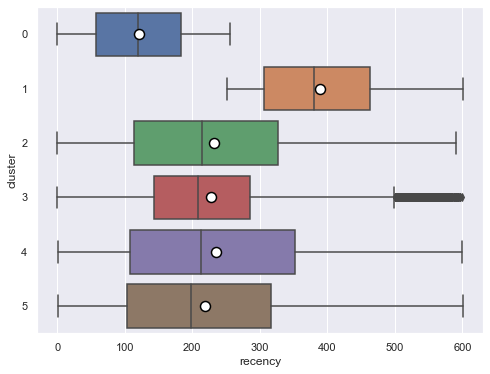

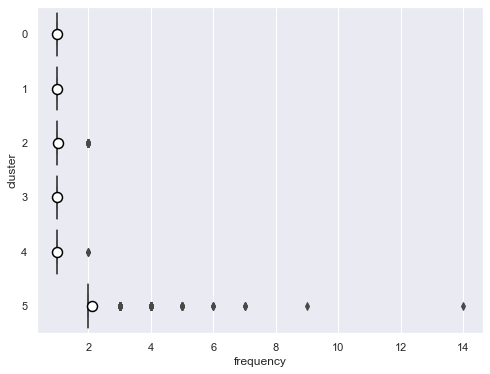

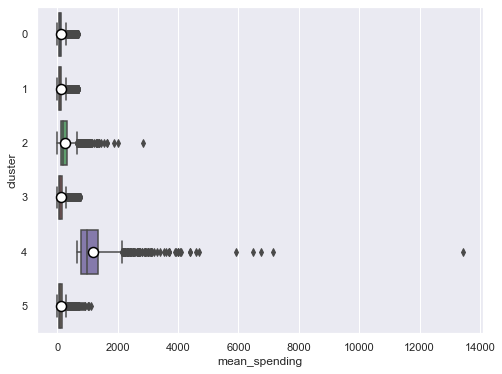

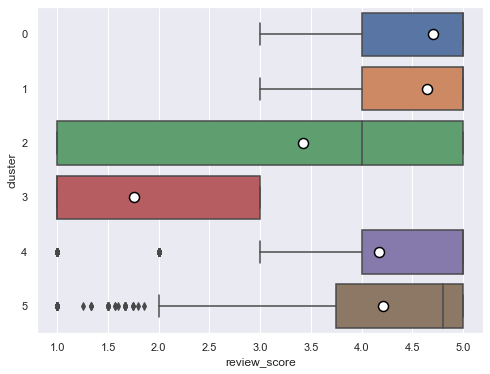

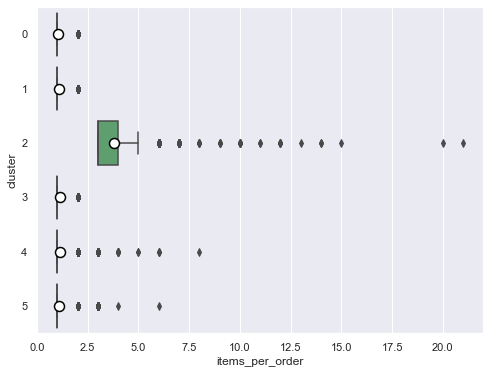

In [5]:
df_rfmsa['cluster'] = clusters

for col in df_rfmsa.columns[:-1]:
    plt.figure(figsize=(8,6))
    sns.boxplot(x=col, y='cluster', data=df_rfmsa, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

# Estimation du délai de maintenance

Pour estimer le délai de maintenance on va comparer le clustering obtenu par un modèle initialisé à une date T$_0$ avec celu obtenu par un modèle initialisé à une date T$_1$ ultérieure. Pour comparer les deux clusterings on va utiliser l'ARI (Adjusted Rand Score) dont la valeur est comprise entre 0 et 1. On va fixer un seuil de 0.8 pour juger de la similarité entre les clusterings, lorsqu'on passe en-dessous de ce seuil, une réinitialisation du modèle est exigée.

In [6]:
from sklearn.metrics.cluster import adjusted_rand_score

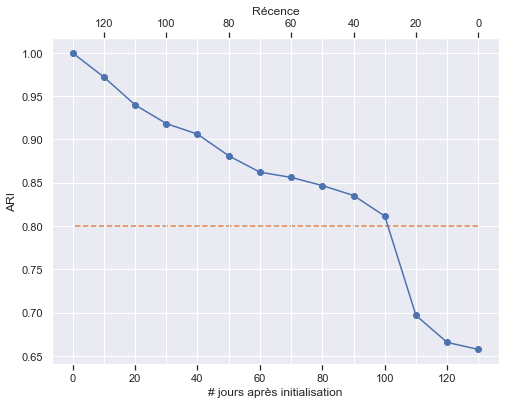

In [7]:
recence_init = 130 # date/récence à laquelle on initialise le modèle initial
days_range = recence_init # nombre de jours où on va calculer l'ARI
days_step = 10 # pas entre deux mesures d'ARI
threshold = .8

# On commence par sélectionner les commandes qui ont été effectuées il y a plus de
# recence_init jours
X_0 = X_rfmsa[X_rfmsa['recency'] > recence_init].copy()

# Model initial
model_init = make_pipeline(StandardScaler(), KMeans(n_clusters=n_clust, random_state=12))
model_init.fit(X_0)

ari = [] # liste qui va contenir les valeurs d'ARI

# On va rajouter toutes les commandes qui ont eu lieu pendant days_range depuis 
# recence_init en faisant des pas de days_step et à chaque pas on va comparer le
# clustering obtenu par l'ancien modèle (model_init) avec celui obtenu par le
# nouveau modèle (model_new) en utilisant l'ARI.
n_days = np.arange(0, days_range+1, days_step)
for n in n_days:
    # On rajoute les commandes qui ont été faites pendant n jours après recence_init
    X_1 = X_rfmsa[X_rfmsa['recency'] > recence_init - n].copy()

    # Clustering avec le modèle initial
    clusters_init = model_init.predict(X_1)

    # On entraîne un nouveau modèle.
    model_new = make_pipeline(StandardScaler(), KMeans(n_clusters=n_clust, random_state=12))
    model_new.fit(X_1)
    # Récupération des clusters attribués à chaque individu
    clusters_new = model_new['kmeans'].labels_

    ari += [adjusted_rand_score(labels_true=clusters_new, labels_pred=clusters_init)]

ari = np.array(ari) # conversion en ndarray

# On trace les valeurs d'ARI
delta = recence_init - days_range
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(n_days[::-1]+delta, np.zeros(n_days.shape)+threshold, '--', color='#dd8452')
ax.set_xlabel('# jours après initialisation')
ax.set_ylabel('ARI')

ax2 = ax.twiny()
ax2.plot(n_days[::-1]+delta, ari, 'o-')
ax2.set_xlabel('Récence')
ax2.invert_xaxis()

plt.show()